# GNN : グラフの分類
フェイクニュース検出を題材として，
データセットに UPFD (The tree-structured fake news propagation graph classification dataset) を用いる。

https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.UPFD

流れは以下のとおり：
1. データセットの読み込み
1. 学習・テストデータへの分割 ＆ DataLoader の定義
1. ネットワークの定義
1. ネットワークの学習
1. ネットワークのテスト
1. 正解率および損失の可視化

In [1]:
# データセットの読み込み
from torch_geometric.datasets import UPFD
# dataset = UPFD(root='.', name='politifact', feature='profile') # 2 class, 10 dimension
# dataset = UPFD(root='.', name='politifact', feature='bert') # 2 class, 768 dimension
dataset = UPFD(root='.', name='gossipcop', feature='bert') # 2 class, 768 dimension
len(dataset)

1092

In [2]:
# クラス数 ＆ ノードの有する特徴の次元をチェック
print(dataset.num_classes)
print(dataset.num_node_features)

2
768


In [3]:
# (参考) １つ目のグラフの特徴ベクトル
dataset[0].x

tensor([[-0.0848, -0.2643, -0.2449,  ..., -0.1209,  0.1636,  0.4188],
        [ 0.1415, -0.0493, -0.1443,  ...,  0.4186, -0.0096,  0.2688],
        [-0.0319,  0.0562,  0.4386,  ...,  0.2217,  0.0694,  0.6907],
        ...,
        [ 0.0231,  0.1641,  0.0682,  ...,  0.4842,  0.0395,  0.8409],
        [-0.0714,  0.1860,  0.1526,  ...,  0.4669, -0.1010,  0.5712],
        [ 0.0569,  0.1775,  0.1596,  ...,  0.5712,  0.0127,  0.5610]])

In [4]:
# データセットの分割 ＆ DataLoader の定義
from torch_geometric.loader import DataLoader

dataset = dataset.shuffle()  # データセットｎシャッフル
train_size = int(len(dataset) * 0.8)
dataset_train = dataset[:train_size]  # 訓練用データセット
dataset_test = dataset[train_size:]  # テスト用データセット

batch_size = 16  # バッチサイズ
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [5]:
# モデルの定義 ＆ インスタンス化
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

n_h = 64  # 中間層における特徴量の数

class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, n_h)
        self.conv2 = GCNConv(n_h, n_h)
        self.fc = nn.Linear(n_h, dataset.num_classes)  # 全結合層

        self.relu = nn.ReLU()  # 活性化関数 ReLU
        self.dropout = nn.Dropout(p=0.2)  # ドロップアウト

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # GCNConv.forward() の第１引数は特徴ベクトル，第２引数は edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)

        # 全てのノードで各特徴量の平均をとる
        x = global_mean_pool(x, batch)  # shape を(バッチサイズ, 特徴量の数)に変換

        x = self.dropout(x)
        x = self.fc(x)
        
        return x

device = device = "cuda" if torch.cuda.is_available() else "cpu"

net = GCN()
net.to(device)

GCN(
  (conv1): GCNConv(768, 64)
  (conv2): GCNConv(64, 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [6]:
# ネットワークの学習

def eval(loader):
    correct = 0  # 正解数

    for data in loader:
        data = data.to(device)
        out = net(data)  
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())

    return correct/len(loader.dataset)  # 正解率

from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

train_acc_log = list()
test_acc_log = list()
train_loss_log = list()

for epoch in range(200):
    # 訓練
    net.train()  # 訓練モード
    for data in loader_train: 
        data = data.to(device)

        optimizer.zero_grad()  # 勾配の初期化
        out = net(data)  # 順伝播により予測値を得る
        loss = loss_fnc(out, data.y)  # 予測値と正解値から損失を計算

        train_loss_log.append(loss.item()) # (メモ) Tensor から値を取り出すため item() を使用
        
        loss.backward()  # 損失からバックプロパゲーションにより勾配を計算
        optimizer.step()  # 最適化アルゴリズムによりパラメータを更新

    # 評価
    net.eval()  # 評価モード
    acc_train = eval(loader_train)
    acc_test = eval(loader_test)
    if (epoch + 1) % 10 == 0:
        print("Epoch:", epoch+1,
              "acc_train:", acc_train,
              "acc_test:", acc_test)
    train_acc_log.append(acc_train)
    test_acc_log.append(acc_test)

Epoch: 10 acc_train: 0.86368843069874 acc_test: 0.8264840182648402
Epoch: 20 acc_train: 0.9415807560137457 acc_test: 0.863013698630137
Epoch: 30 acc_train: 0.9679266895761741 acc_test: 0.867579908675799
Epoch: 40 acc_train: 0.9908361970217641 acc_test: 0.8584474885844748
Epoch: 50 acc_train: 1.0 acc_test: 0.863013698630137
Epoch: 60 acc_train: 1.0 acc_test: 0.8721461187214612
Epoch: 70 acc_train: 1.0 acc_test: 0.8721461187214612
Epoch: 80 acc_train: 1.0 acc_test: 0.867579908675799
Epoch: 90 acc_train: 1.0 acc_test: 0.8538812785388128
Epoch: 100 acc_train: 1.0 acc_test: 0.8447488584474886
Epoch: 110 acc_train: 1.0 acc_test: 0.8584474885844748
Epoch: 120 acc_train: 1.0 acc_test: 0.8584474885844748
Epoch: 130 acc_train: 1.0 acc_test: 0.8584474885844748
Epoch: 140 acc_train: 1.0 acc_test: 0.8584474885844748
Epoch: 150 acc_train: 1.0 acc_test: 0.8493150684931506
Epoch: 160 acc_train: 1.0 acc_test: 0.8584474885844748
Epoch: 170 acc_train: 1.0 acc_test: 0.8538812785388128
Epoch: 180 acc_train

In [7]:
# テストデータセットの評価
net.eval()  # 評価モード
acc_test = eval(loader_test)
print("accuracy:", acc_test)

accuracy: 0.8767123287671232


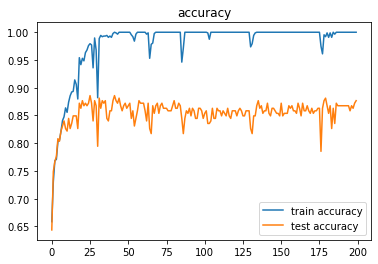

In [8]:
# 正解率の可視化
import matplotlib.pyplot as plt

plt.plot(train_acc_log, label="train accuracy")
plt.plot(test_acc_log, label="test accuracy")
plt.title("accuracy")
plt.legend()
plt.show()

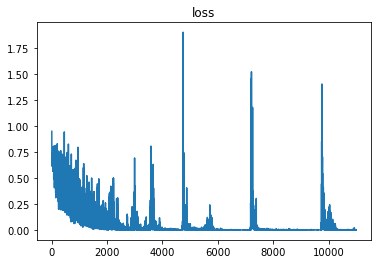

In [9]:
# 損失の可視化
import matplotlib.pyplot as plt

plt.plot(train_loss_log, label="train accuracy")
plt.title("loss")
plt.show()